# CS446/519 - Class Session 20 - Partial correlation network

In this class session we will continue with analyzing the bladder cancer gene expression dataset.  We'll restrict our attention to a small set of 164 genes that are very highly expressed in cancer (just to keep the analysis simple).  We'll construct a simple "partial correlation network" from the data.

Read the tab-deliminted text file of gene expression measurements (rows correspond to genes, columns correspond to bladder tumor samples). (use Pandas, `pandas.read.csv`, and `as_matrix`). As always, sanity check that the file that you loaded has the expected dimensions (4,473 x 414) using `shape`.

In [1]:
import pandas
gene_matrix_for_network_df = pandas.read_csv("shared/bladder_cancer_genes_tcga.txt", sep="\t")
gene_matrix_for_network = gene_matrix_for_network_df.as_matrix()
print(gene_matrix_for_network.shape)

(4473, 414)


Filter the matrix to include only rows for which the column-wise median is > 12; matrix should now be 164 x 414; this is not strictly necessary but will help prevent us from over-burderning the EC2 instance and it will enable us to easily compute the partial correlation matrix using the inverse of the covariance matrix. Print the size of the filtered matrix, as a sanity check.

In [4]:
import numpy
gene_matrix_np = numpy.array(gene_matrix_for_network)
genes_keep = numpy.where(numpy.median(gene_matrix_np, axis=1) > 12)
matrix_filt = gene_matrix_np[genes_keep, ][0]
matrix_filt.shape
N = matrix_filt.shape[0]

Compute the 164 x 164 matrix of gene-gene Pearson correlation coefficients, using `numpy.corrcoef` (this function treats each row as a random variable, so you don't have to do any transposing of the matrix, unlike the situation in R). 

In [5]:
matrix_cor = numpy.corrcoef(matrix_filt)

Compute the partial correlation coefficient matrix using `sklearn.covariance.empirical_covariance` (from the `sklearn.covariance` package, then using `numpy.linalg.inv` to get the inverse matrix. Make sure you take the transpose of the `matrix_filt` matrix before passing it to the `empirical_covariance` function!  Print the dimensions of the matrix you get back, as a sanity check. 

In [6]:
import sklearn.covariance
matrix_cov = sklearn.covariance.empirical_covariance(numpy.matrix.transpose(matrix_filt))
matrix_cov_inv = numpy.linalg.inv(matrix_cov)
matrix_pcor = -matrix_cov_inv
for i in range(N):
    for j in range(N):
        matrix_pcor[i,j] /= numpy.sqrt(matrix_cov_inv[i,i]*matrix_cov_inv[j,j])
print(matrix_pcor.shape)

(164, 164)
(164, 164)


Get the correlation coefficients and the partial correlation coefficients of the lower triangle of the matrix (not including the diagonal), as two vectors `cor_values` and `pcor_values`; your resulting vectors should each have length 13,366.  You will want to use `numpy.tri` and `numpy.where` (see class session 19 exercise)

In [10]:
cor_values = matrix_cor[numpy.where(numpy.tri(*matrix_cor.shape, k=-1))]
pcor_values = matrix_pcor[numpy.where(numpy.tri(*matrix_pcor.shape, k=-1))]
print(len(cor_values))
print(len(pcor_values))

13366
13366


plot the histograms of the correlation coefficients (upper triangle only) and the partial correlation coefficients, on the same plot using alpha blending (refer to class session 17 exercise)

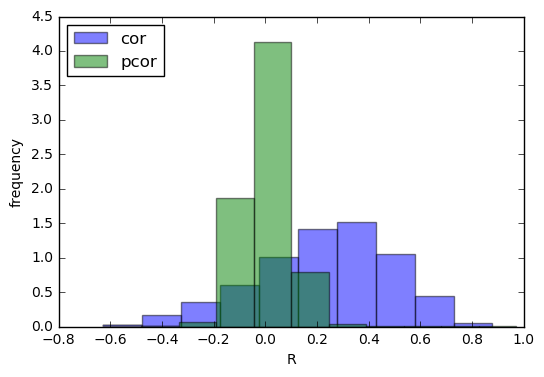

In [9]:
import matplotlib.pyplot
matplotlib.pyplot.hist(cor_values, normed=1, alpha=0.5, label="cor")
matplotlib.pyplot.hist(pcor_values, normed=1, alpha=0.5, label="pcor")
matplotlib.pyplot.legend(loc="upper left")
matplotlib.pyplot.xlabel("R")
matplotlib.pyplot.ylabel("frequency")
matplotlib.pyplot.show()

Fisher transform the partial correlation values, using `numpy.log`

In [13]:
z_scores = 0.5*numpy.log((1+pcor_values)/
                         (1-pcor_values))

Compute a p-value for each gene pair (upper triangle only), using the fact that sqrt(M-N-5) times the fisher Z sore should be approximately univariate normal (with zero mean) under the null hypothesis that a given gene pair's measurements (conditioned on the measurements for all the other 162 genes) are independent. You will want to use `scipy.stats.norm.cdf`, `numpy.abs`, and the `**` operator (see class session 19 exercise).

In [14]:
M = gene_matrix_for_network_df.shape[1]
import scipy.stats
P_values = 2*scipy.stats.norm.cdf(-numpy.abs(z_scores)*((M-N-5)**0.5))

How many gene pairs have a P value less than 0.01? (use `which` and `length`)

In [19]:
len(numpy.where(P_values < 0.01)[0])

706

What are the sizes of the components in the undirected graph whose edges have `P < 0.05` in the statistical test that you did?  You will need to use `zip`, `tolist`, `list`, and `igraph.Graph.TupleList` (see class session 19 exercise)

In [43]:
import igraph
inds_tri = numpy.where(numpy.tri(*matrix_pcor.shape, k=-1))
inds_sig = numpy.where(P_values < 0.01)
graph_edge_list = list(zip(inds_tri[1][inds_sig].tolist(),
                                                inds_tri[0][inds_sig].tolist()))
final_network = igraph.Graph.TupleList(graph_edge_list, directed=False)
final_network.summary()

'IGRAPH UN-- 164 706 -- \n+ attr: name (v)'

Plot the graph degree distribution on log-log scale

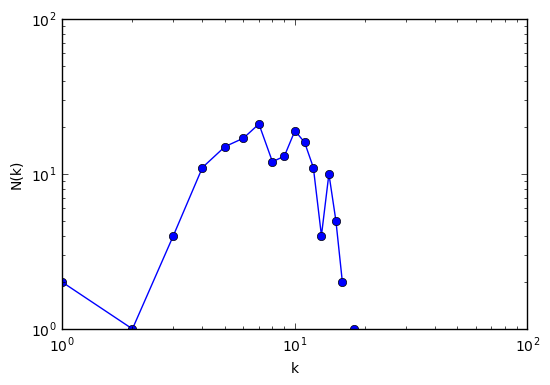

In [45]:
import matplotlib
import pylab
degree_dist = final_network.degree_distribution()
xs, ys = zip(*[(left, count) for left, _, count in degree_dist.bins()])
matplotlib.pyplot.loglog(xs, ys, marker="o")
pylab.xlabel("k")
pylab.ylabel("N(k)")
pylab.show()